copied and edited from:\
https://machinelearningmastery.com/how-to-develop-a-generative-adversarial-network-for-an-mnist-handwritten-digits-from-scratch-in-keras/

In [1]:
# How to check if the code is running on GPU or CPU?

from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 17258096033934557640
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 6686252073
locality {
  bus_id: 1
  links {
  }
}
incarnation: 17633812593104753419
physical_device_desc: "device: 0, name: GeForce GTX 1070, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


In [2]:
!nvidia-smi

Tue Apr 28 13:59:00 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 432.00       Driver Version: 432.00       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 1070   WDDM  | 00000000:01:00.0  On |                  N/A |
| 50%   62C    P2    37W / 151W |    544MiB /  8192MiB |      1%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [17]:
# example of training a gan on mnist
from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy import vstack
from numpy.random import randn
from numpy.random import randint
from keras.datasets.mnist import load_data
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Dropout
from matplotlib import pyplot

# define the standalone discriminator model
def define_discriminator(in_shape=(28,28,1)):
    model = Sequential()
    model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same', input_shape=in_shape))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))
    model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

# define the standalone generator model
def define_generator(latent_dim):
    model = Sequential()
    # foundation for 7x7 image
    n_nodes = 128 * 7 * 7
    model.add(Dense(n_nodes, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((7, 7, 128)))
    # upsample to 14x14
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # upsample to 28x28
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(1, (7,7), activation='sigmoid', padding='same'))
    return model

# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
    # make weights in the discriminator not trainable
    d_model.trainable = False
    # connect them
    model = Sequential()
    # add generator
    model.add(g_model)
    # add the discriminator
    model.add(d_model)
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model

# load and prepare mnist training images
def load_real_samples():
    # load mnist dataset
    (trainX, _), (_, _) = load_data()
    # expand to 3d, e.g. add channels dimension
    X = expand_dims(trainX, axis=-1)
    # convert from unsigned ints to floats
    X = X.astype('float32')
    # scale from [0,255] to [0,1]
    X = X / 255.0
    return X

# select real samples
def generate_real_samples(dataset, n_samples):
    # choose random instances
    ix = randint(0, dataset.shape[0], n_samples)
    # retrieve selected images
    X = dataset[ix]
    # generate 'real' class labels (1)
    y = ones((n_samples, 1))
    return X, y

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input

# use the generator to generate n fake examples, with class labels
def generate_fake_samples(g_model, latent_dim, n_samples):
    # generate points in latent space
    x_input = generate_latent_points(latent_dim, n_samples)
    # predict outputs
    X = g_model.predict(x_input)
    # create 'fake' class labels (0)
    y = zeros((n_samples, 1))
    return X, y

# create and save a plot of generated images (reversed grayscale)
def save_plot(examples, epoch, n=10):
    # plot images
    for i in range(n * n):
        # define subplot
        pyplot.subplot(n, n, 1 + i)
        # turn off axis
        pyplot.axis('off')
        # plot raw pixel data
        pyplot.imshow(examples[i, :, :, 0], cmap='gray_r')
    # save plot to file
    filename = 'generated_plot_e%03d.png' % (epoch+1)
    pyplot.savefig(filename)
    pyplot.close()

# evaluate the discriminator, plot generated images, save generator model
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=100):
    # prepare real samples
    X_real, y_real = generate_real_samples(dataset, n_samples)
    # evaluate discriminator on real examples
    _, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
    # prepare fake examples
    x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
    # evaluate discriminator on fake examples
    _, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)\
    # summarize discriminator performance\
    print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
    # save plot
    save_plot(x_fake, epoch)
    # save the generator model tile file
    filename = 'generator_model_%03d.h5' % (epoch + 1)
    g_model.save(filename)

# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=200, n_batch=256):
    bat_per_epo = int(dataset.shape[0] / n_batch)
    half_batch = int(n_batch / 2)
    # manually enumerate epochs
    for i in range(n_epochs):
        # enumerate batches over the training set
        for j in range(bat_per_epo):
            # get randomly selected 'real' samples
            X_real, y_real = generate_real_samples(dataset, half_batch)
            # generate 'fake' examples
            X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
            # create training set for the discriminator
            X, y = vstack((X_real, X_fake)), vstack((y_real, y_fake))
            # update discriminator model weights
            d_loss, _ = d_model.train_on_batch(X, y)
            # prepare points in latent space as input for the generator
            X_gan = generate_latent_points(latent_dim, n_batch)
            # create inverted labels for the fake samples
            y_gan = ones((n_batch, 1))
            # update the generator via the discriminator's error
            g_loss = gan_model.train_on_batch(X_gan, y_gan)
            # summarize loss on this batch
            if (j+1) == bat_per_epo:
                print('>%d, %d/%d, d=%.3f, g=%.3f' % (i+1, j+1, bat_per_epo, d_loss, g_loss))
        # evaluate the model performance, sometimes
        if (i+1) % 10 == 0:
            summarize_performance(i, g_model, d_model, dataset, latent_dim)

In [18]:
# size of the latent space
latent_dim = 100
# create the discriminator
d_model = define_discriminator()
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)
# load image data
dataset = load_real_samples()
# train model
train(g_model, d_model, gan_model, dataset, latent_dim)

C:\ProgramData\Anaconda3\envs\project\lib\site-packages\keras\engine\training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
C:\ProgramData\Anaconda3\envs\project\lib\site-packages\keras\engine\training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


>1, 234/234, d=0.932, g=0.691
>2, 234/234, d=0.651, g=0.772
>3, 234/234, d=0.707, g=0.704
>4, 234/234, d=0.685, g=0.723
>5, 234/234, d=0.684, g=0.689
>6, 234/234, d=0.691, g=0.723
>7, 234/234, d=0.689, g=0.728
>8, 234/234, d=0.673, g=0.739
>9, 234/234, d=0.699, g=0.683
>10, 234/234, d=0.678, g=0.711
>Accuracy real: 67%, fake: 54%
>11, 234/234, d=0.680, g=0.694
>12, 234/234, d=0.694, g=0.741
>13, 234/234, d=0.696, g=0.684
>14, 234/234, d=0.684, g=0.723
>15, 234/234, d=0.687, g=0.741
>16, 234/234, d=0.685, g=0.714
>17, 234/234, d=0.684, g=0.711
>18, 234/234, d=0.687, g=0.714
>19, 234/234, d=0.689, g=0.718
>20, 234/234, d=0.685, g=0.716
>Accuracy real: 72%, fake: 55%
>21, 234/234, d=0.686, g=0.723
>22, 234/234, d=0.678, g=0.724
>23, 234/234, d=0.692, g=0.727
>24, 234/234, d=0.698, g=0.692
>25, 234/234, d=0.682, g=0.674
>26, 234/234, d=0.691, g=0.731
>27, 234/234, d=0.681, g=0.711
>28, 234/234, d=0.687, g=0.719
>29, 234/234, d=0.686, g=0.766
>30, 234/234, d=0.684, g=0.701
>Accuracy real: 8

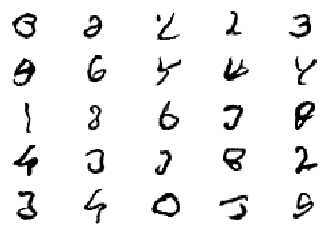

In [20]:
# example of loading the generator model and generating images
from keras.models import load_model
from numpy.random import randn
from matplotlib import pyplot

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input

# create and save a plot of generated images (reversed grayscale)
def save_plot(examples, n):
    # plot images
    for i in range(n * n):
        # define subplot
        pyplot.subplot(n, n, 1 + i)
        # turn off axis
        pyplot.axis('off')
        # plot raw pixel data
        pyplot.imshow(examples[i, :, :, 0], cmap='gray_r')
    pyplot.show()

# load model
model = load_model('generator_model_200.h5')
# generate images
latent_points = generate_latent_points(100, 25)
# generate images
X = model.predict(latent_points)
# plot the result
save_plot(X, 5)

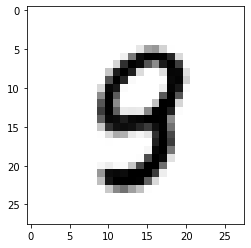

In [21]:
# example of generating an image for a specific point in the latent space
from keras.models import load_model
from numpy import asarray
import matplotlib.pyplot as plt
# load model
model = load_model('generator_model_200.h5')
# all 0s
vector = asarray([[0.0 for _ in range(100)]])
# generate image
X = model.predict(vector)
# plot the result
plt.imshow(X[0, :, :, 0], cmap='gray_r')
plt.show()

In [22]:
from keras.models import load_model
from sklearn.manifold import TSNE
import numpy as np

epoch = 200
# save the discriminator model tile file
d_filename = 'discriminator_model_%03d.h5' % (epoch)
d_model.save(d_filename)

In [23]:
# load test data
(trainX, _), (_, _) = load_data()

# expand to 3d, e.g. add channels dimension
X = expand_dims(trainX, axis=-1)

# convert from unsigned ints to floats
X = X.astype('float32')

# scale from [0,255] to [0,1]
X = X / 255.0

(1000, 28, 28, 1)
(1000, 28, 28, 1)
a sample from generated anomaly images


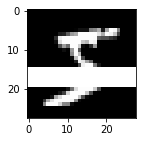

In [29]:
# 줄 낙서 (비교군)
X_anomal = X[:1000]
X_anomal[:, 15:20, :] = 1.
print(X_anomal.shape) #(1000, 28, 28, 1)

# mnist (대조군)
X_normal = X[1000:2000]
print(X_normal.shape) #(2000, 28, 28, 1)

print("a sample from generated anomaly images")
plt.figure(figsize=(2, 2))
plt.imshow(X_anomal[0].reshape(28,28), cmap=pyplot.cm.gray)
plt.show()

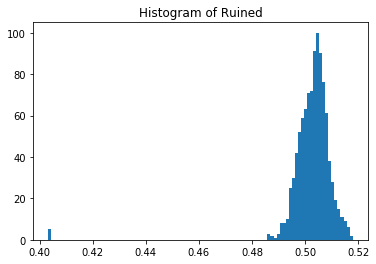

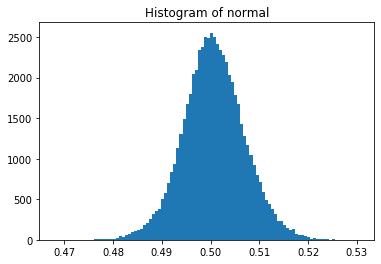

In [32]:
# 모델 load 안 된 상태에서 predict

predicted_normal = d_model.predict(X_real)
predicted_ruined = d_model.predict(X_anomal)

plt.hist(predicted_ruined, bins=100)
plt.title('Histogram of Ruined')
plt.show()
plt.hist(predicted_normal, bins=100)
plt.title('Histogram of normal')
plt.show()

60000/60000 [==============================] - 3s 55us/step


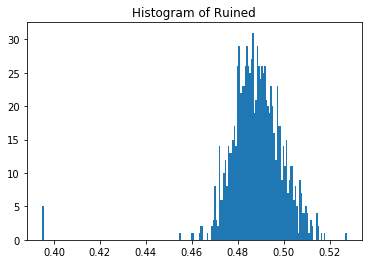

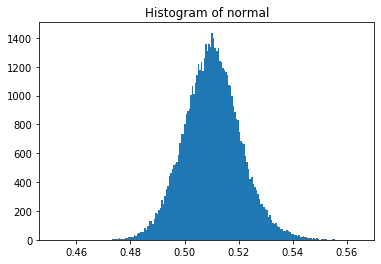

In [33]:
# load discriminator model
model = load_model('discriminator_model_100.h5')


# proceed loaded model
predicted_ruined = model.predict(X_anomal, verbose=1)
predicted_normal = model.predict(X_real, verbose=1)

plt.hist(predicted_ruined, bins=200)
plt.title('Histogram of Ruined')
plt.show()
plt.hist(predicted_normal, bins=200)
plt.title('Histogram of normal')
plt.show()